In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
notes_path = '../mimic-iii-clinical-database-1.4/NOTEEVENTS.csv.gz'
diagnoses_path = '../mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv.gz'

In [3]:
notes_df = pd.read_csv(notes_path, low_memory=False, compression='gzip')
diagnoses_df = pd.read_csv(diagnoses_path, low_memory=False, compression='gzip')

In [4]:
notes_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT'],
      dtype='object')

In [5]:
diagnoses_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')

I will be focusing this assignment on Pneumonia with ICD9 code 486.

In [ ]:
# Filter diagnoses for icd9 codes: 995.91 and 995.92. Find notes for these hospitalization
icd_code = '486'
pneumonia_diagnoses_df = diagnoses_df[diagnoses_df['ICD9_CODE'] == icd_code]

# print(pneumonia_diagnoses_df.head())

# Find rows where category is "Discharge Summary" and "subject_id"
only_discharge_summs_df = notes_df.loc[notes_df['CATEGORY'] == 'Discharge summary', ['SUBJECT_ID', 'HADM_ID', 'TEXT']]
pneumonia_notes_df = only_discharge_summs_df.merge(pneumonia_diagnoses_df[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']], on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Verify that only pneumonia is present
pneumonia_notes_df['ICD9_CODE'].value_counts()

ICD9_CODE
486    5357
Name: count, dtype: int64

In [7]:
# Since there are too many rows, save the first 100 to a CSV file
pneumonia_notes_path = 'pneumonia_notes.csv'
pneumonia_notes_df_filtered = pneumonia_notes_df[:100]
pneumonia_notes_df_filtered.to_csv(pneumonia_notes_path)
pneumonia_notes_df_filtered.shape

(100, 4)

It's time to do entity extraction using Spacy and SciSpacy.

python -m spacy download en_core_web_sm
pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz

In [10]:
import spacy
from spacy import displacy
nlp_spacy = spacy.load('en_core_web_sm')
nlp_scispacy = spacy.load("en_core_sci_sm")

In [11]:
# Load our filtered pneumonia notes data
pneumonia_notes_df = pd.read_csv('pneumonia_notes.csv')

In [12]:
def extract_entities(text, model):
    doc = model(text)
    entities = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    return entities

In [ ]:
# Extract entities from discharge summary text using Spacy
def extract_and_visualize_entities(df, model, limit=5):
    for index, row in df.iterrows():
        text = row['TEXT']
        subject_id = row["SUBJECT_ID"]
        hadm_id = row["HADM_ID"]

        doc = model(text)
        displacy.render(doc, style='ent', jupyter=True)
        
        print(f"\n--- NOTE {index+1} (SUBJECT_ID: {subject_id}, HADM_ID: {hadm_id}) ---")
        print(f"TEXT:\n{text}\n")
        print("*" * 80)

        if index == limit:
            break

In [14]:
extract_and_visualize_entities(pneumonia_notes_df, nlp_spacy)


--- NOTE 1 (SUBJECT_ID: 13702, HADM_ID: 107527.0) ---
TEXT:
Admission Date:  [**2118-6-2**]       Discharge Date:  [**2118-6-14**]

Date of Birth:                    Sex:  F

Service:  MICU and then to [**Doctor Last Name **] Medicine

HISTORY OF PRESENT ILLNESS:  This is an 81-year-old female
with a history of emphysema (not on home O2), who presents
with three days of shortness of breath thought by her primary
care doctor to be a COPD flare.  Two days prior to admission,
she was started on a prednisone taper and one day prior to
admission she required oxygen at home in order to maintain
oxygen saturation greater than 90%.  She has also been on
levofloxacin and nebulizers, and was not getting better, and
presented to the [**Hospital1 18**] Emergency Room.

In the [**Hospital3 **] Emergency Room, her oxygen saturation was
100% on CPAP.  She was not able to be weaned off of this
despite nebulizer treatment and Solu-Medrol 125 mg IV x2.

Review of systems is negative for the following: 


--- NOTE 2 (SUBJECT_ID: 20646, HADM_ID: 134727.0) ---
TEXT:
Admission Date:  [**2112-12-8**]              Discharge Date:   [**2112-12-10**]


Service: MEDICINE

Allergies:
Sulfonamides

Attending:[**First Name3 (LF) 1850**]
Chief Complaint:
Hypoxia

Major Surgical or Invasive Procedure:
none

History of Present Illness:
82 yo F with CAD, CHF, HTN, recent PE ([**10-17**]), who presents from
rehab with hypoxia and SOB despite Abx treatment for PNA x 3
days. The patient was in rehab after being discharged from here
for PE. She was scheduled to be discharged on [**12-6**]; on the day
prior to discharge she deveoped fever, hypoxia, and SOB. CXR
showed b/t lower lobe infiltrates. She was started on levoflox
and ceftriaxone on [**12-5**]. When she became hypoxic on NC they
brought her in to the ED.
.
In the [**Hospital1 18**] ED she was febrile to 102.7, P 109 BP 135/56 R 34
O2 90% on 3L. She was started on vanc and zosyn for broader
coverage, tylenol, and 2L NS.
.
The patient reports havin


--- NOTE 3 (SUBJECT_ID: 1136, HADM_ID: 139574.0) ---
TEXT:
Admission Date:  [**2192-4-19**]              Discharge Date:   [**2192-5-23**]


Service: MEDICINE

Allergies:
Lisinopril

Attending:[**First Name3 (LF) 1865**]
Chief Complaint:
Diarrhea

Major Surgical or Invasive Procedure:
None

History of Present Illness:
Mrs. [**Known lastname **] is an 84 yo f h/o CRI, HTN, GERD, colon ca,
neprhotic syndrome, dc'd [**3-31**] after low anterior resection of
colon. Now p/w 1wk h/o diarrhea worsened one day prior to
admission, found to have wbcc 30 in ED, admitted [**4-19**] and
started on both p.o. vanco and IV flagyl. Began to have brbpr on
[**4-25**], on [**4-30**] had flex sigmoidoscopy showing pseudomembranes with
recurrent c.diff vs. bowel ischemia as etiology. Then developed
some sob/fluid overload and was started on lasix and neseritide
gtt's. Had had some intermittent afib which was thought to be
contributing to presumed diastolic dysfunction. Tx to CCU
[**2192-5-12**] for worseni


--- NOTE 4 (SUBJECT_ID: 70108, HADM_ID: 186093.0) ---
TEXT:
Admission Date:  [**2105-4-16**]              Discharge Date:   [**2105-4-27**]

Date of Birth:  [**2044-3-8**]             Sex:   F

Service: MEDICINE

Allergies:
Penicillins

Attending:[**First Name3 (LF) 2344**]
Chief Complaint:
Airway monitoring

Major Surgical or Invasive Procedure:
[**2105-4-24**]: Right video-assisted thoraoscopy with decortication


History of Present Illness:
61 year old female with PMHX of HTH presented with severe sore
throat for 2 days rapidly getting worse associated with
difficulty swallowing liquids and neck pain. Also found to have
fever and tachycardia. Unable to take meds, only took BP meds
this am. Voice is hoarse and descrbed as "hot potato" by PCP.
[**Name10 (NameIs) 1403**] as a flight attendant, travelled all over Europe recently.
Sister with sore throat as well. In PCPs office, unable to open
her mouth, tender thick neck unable to evaluate pharynx. Per
report pts sore throat has progre


--- NOTE 5 (SUBJECT_ID: 96774, HADM_ID: 129414.0) ---
TEXT:
Admission Date:  [**2174-2-12**]              Discharge Date:   [**2174-2-14**]

Date of Birth:  [**2122-4-28**]             Sex:   M

Service: MEDICINE

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 2474**]
Chief Complaint:
shortness of breath

Major Surgical or Invasive Procedure:
None


History of Present Illness:
51 yo M with h/o asthma and right lung volume loss of unclear
etiology (?congenital hypoplasia), recurrent bronchitis in
winter, OSA, obesity, HTN who presented with 1 week of
productive cough, progresssive SOB, and over the past 2 days
weakness and fatigue to the point he was falling asleep at work.
He tried increasing his albuterol use but this did not help so
he came to the emergency room.

In the ED, initial vs were: T: 99.5 P109 BP101/56 R24 79% on RA
on presentation, 100% on NRB. The ED resident noted that he was
not particularly wheezy on exam. Labs notabl


--- NOTE 6 (SUBJECT_ID: 22180, HADM_ID: 186367.0) ---
TEXT:
Admission Date:  [**2134-8-12**]              Discharge Date:   [**2134-8-20**]


Service: MEDICINE

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 1974**]
Chief Complaint:
Dyspnea

Major Surgical or Invasive Procedure:
Intubation

History of Present Illness:
82yo Russian speaking F with a PMH of type II DM, HTN,
hyperlipidemia, obesity, pulmonary HTN and anemia, who presented
to the ED this AM with worsening SOB x 2 weeks. Per the ED
resident, the patient noted that she had had worsening SOB x 2
weeks (documented as 2 days [**Name8 (MD) **] RN note) and also complained of
orthopnea and increasing lower extremity swelling and weeping
from a venous stasis ulcer on her L shin. The patient was able
to communicate this verbally to ER resident (RN notes she was
only able to speak in 4 word sentences). Her VNA stated that she
was only 94% on 2L O2 at home and had rales [**12-28**] w

In [15]:
# Extract entities using Sci Spacy
extract_and_visualize_entities(pneumonia_notes_df, nlp_scispacy)


--- NOTE 1 (SUBJECT_ID: 13702, HADM_ID: 107527.0) ---
TEXT:
Admission Date:  [**2118-6-2**]       Discharge Date:  [**2118-6-14**]

Date of Birth:                    Sex:  F

Service:  MICU and then to [**Doctor Last Name **] Medicine

HISTORY OF PRESENT ILLNESS:  This is an 81-year-old female
with a history of emphysema (not on home O2), who presents
with three days of shortness of breath thought by her primary
care doctor to be a COPD flare.  Two days prior to admission,
she was started on a prednisone taper and one day prior to
admission she required oxygen at home in order to maintain
oxygen saturation greater than 90%.  She has also been on
levofloxacin and nebulizers, and was not getting better, and
presented to the [**Hospital1 18**] Emergency Room.

In the [**Hospital3 **] Emergency Room, her oxygen saturation was
100% on CPAP.  She was not able to be weaned off of this
despite nebulizer treatment and Solu-Medrol 125 mg IV x2.

Review of systems is negative for the following: 


--- NOTE 2 (SUBJECT_ID: 20646, HADM_ID: 134727.0) ---
TEXT:
Admission Date:  [**2112-12-8**]              Discharge Date:   [**2112-12-10**]


Service: MEDICINE

Allergies:
Sulfonamides

Attending:[**First Name3 (LF) 1850**]
Chief Complaint:
Hypoxia

Major Surgical or Invasive Procedure:
none

History of Present Illness:
82 yo F with CAD, CHF, HTN, recent PE ([**10-17**]), who presents from
rehab with hypoxia and SOB despite Abx treatment for PNA x 3
days. The patient was in rehab after being discharged from here
for PE. She was scheduled to be discharged on [**12-6**]; on the day
prior to discharge she deveoped fever, hypoxia, and SOB. CXR
showed b/t lower lobe infiltrates. She was started on levoflox
and ceftriaxone on [**12-5**]. When she became hypoxic on NC they
brought her in to the ED.
.
In the [**Hospital1 18**] ED she was febrile to 102.7, P 109 BP 135/56 R 34
O2 90% on 3L. She was started on vanc and zosyn for broader
coverage, tylenol, and 2L NS.
.
The patient reports havin


--- NOTE 3 (SUBJECT_ID: 1136, HADM_ID: 139574.0) ---
TEXT:
Admission Date:  [**2192-4-19**]              Discharge Date:   [**2192-5-23**]


Service: MEDICINE

Allergies:
Lisinopril

Attending:[**First Name3 (LF) 1865**]
Chief Complaint:
Diarrhea

Major Surgical or Invasive Procedure:
None

History of Present Illness:
Mrs. [**Known lastname **] is an 84 yo f h/o CRI, HTN, GERD, colon ca,
neprhotic syndrome, dc'd [**3-31**] after low anterior resection of
colon. Now p/w 1wk h/o diarrhea worsened one day prior to
admission, found to have wbcc 30 in ED, admitted [**4-19**] and
started on both p.o. vanco and IV flagyl. Began to have brbpr on
[**4-25**], on [**4-30**] had flex sigmoidoscopy showing pseudomembranes with
recurrent c.diff vs. bowel ischemia as etiology. Then developed
some sob/fluid overload and was started on lasix and neseritide
gtt's. Had had some intermittent afib which was thought to be
contributing to presumed diastolic dysfunction. Tx to CCU
[**2192-5-12**] for worseni


--- NOTE 4 (SUBJECT_ID: 70108, HADM_ID: 186093.0) ---
TEXT:
Admission Date:  [**2105-4-16**]              Discharge Date:   [**2105-4-27**]

Date of Birth:  [**2044-3-8**]             Sex:   F

Service: MEDICINE

Allergies:
Penicillins

Attending:[**First Name3 (LF) 2344**]
Chief Complaint:
Airway monitoring

Major Surgical or Invasive Procedure:
[**2105-4-24**]: Right video-assisted thoraoscopy with decortication


History of Present Illness:
61 year old female with PMHX of HTH presented with severe sore
throat for 2 days rapidly getting worse associated with
difficulty swallowing liquids and neck pain. Also found to have
fever and tachycardia. Unable to take meds, only took BP meds
this am. Voice is hoarse and descrbed as "hot potato" by PCP.
[**Name10 (NameIs) 1403**] as a flight attendant, travelled all over Europe recently.
Sister with sore throat as well. In PCPs office, unable to open
her mouth, tender thick neck unable to evaluate pharynx. Per
report pts sore throat has progre


--- NOTE 5 (SUBJECT_ID: 96774, HADM_ID: 129414.0) ---
TEXT:
Admission Date:  [**2174-2-12**]              Discharge Date:   [**2174-2-14**]

Date of Birth:  [**2122-4-28**]             Sex:   M

Service: MEDICINE

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 2474**]
Chief Complaint:
shortness of breath

Major Surgical or Invasive Procedure:
None


History of Present Illness:
51 yo M with h/o asthma and right lung volume loss of unclear
etiology (?congenital hypoplasia), recurrent bronchitis in
winter, OSA, obesity, HTN who presented with 1 week of
productive cough, progresssive SOB, and over the past 2 days
weakness and fatigue to the point he was falling asleep at work.
He tried increasing his albuterol use but this did not help so
he came to the emergency room.

In the ED, initial vs were: T: 99.5 P109 BP101/56 R24 79% on RA
on presentation, 100% on NRB. The ED resident noted that he was
not particularly wheezy on exam. Labs notabl


--- NOTE 6 (SUBJECT_ID: 22180, HADM_ID: 186367.0) ---
TEXT:
Admission Date:  [**2134-8-12**]              Discharge Date:   [**2134-8-20**]


Service: MEDICINE

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 1974**]
Chief Complaint:
Dyspnea

Major Surgical or Invasive Procedure:
Intubation

History of Present Illness:
82yo Russian speaking F with a PMH of type II DM, HTN,
hyperlipidemia, obesity, pulmonary HTN and anemia, who presented
to the ED this AM with worsening SOB x 2 weeks. Per the ED
resident, the patient noted that she had had worsening SOB x 2
weeks (documented as 2 days [**Name8 (MD) **] RN note) and also complained of
orthopnea and increasing lower extremity swelling and weeping
from a venous stasis ulcer on her L shin. The patient was able
to communicate this verbally to ER resident (RN notes she was
only able to speak in 4 word sentences). Her VNA stated that she
was only 94% on 2L O2 at home and had rales [**12-28**] w

Now let's experiment with Word2Vec via GenSim.

In [29]:
from gensim.models import Word2Vec
import gensim
import gensim.downloader as api
import re

In [17]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.split()

We are training a completely new word2vec model here.

In [18]:
sentences = pneumonia_notes_df["TEXT"].dropna().apply(preprocess_text).tolist()
model_newly_trained = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

In [20]:
for pair in model_newly_trained.wv.most_similar("pneumonia", topn=10):
    print(pair)

('likely', 0.9825876951217651)
('improvement', 0.9804078936576843)
('improved', 0.979619562625885)
('hypoxia', 0.977623701095581)
('secondary', 0.9773554801940918)
('pressures', 0.9735159873962402)
('due', 0.9733886122703552)
('it', 0.9720855951309204)
('most', 0.9706618785858154)
('some', 0.9704832434654236)


In [25]:
from sklearn.manifold import TSNE

In [31]:
# Taken from the lectures for tSNE visualization
def tsne_plot(model,words, sample_size=-1, preTrained=False):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    # randomly sample words with sample size
    sampled_words = words
    if sample_size != -1:
        sampled_words = np.random.choice(words, size=sample_size, replace=False)

    for word in sampled_words:
      if preTrained:
          tokens.append(model[word])
      else:
          tokens.append(model.wv[word])
      labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

c:\Users\william\dev\ut-austin\ai-in-healthcare\.health-310\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


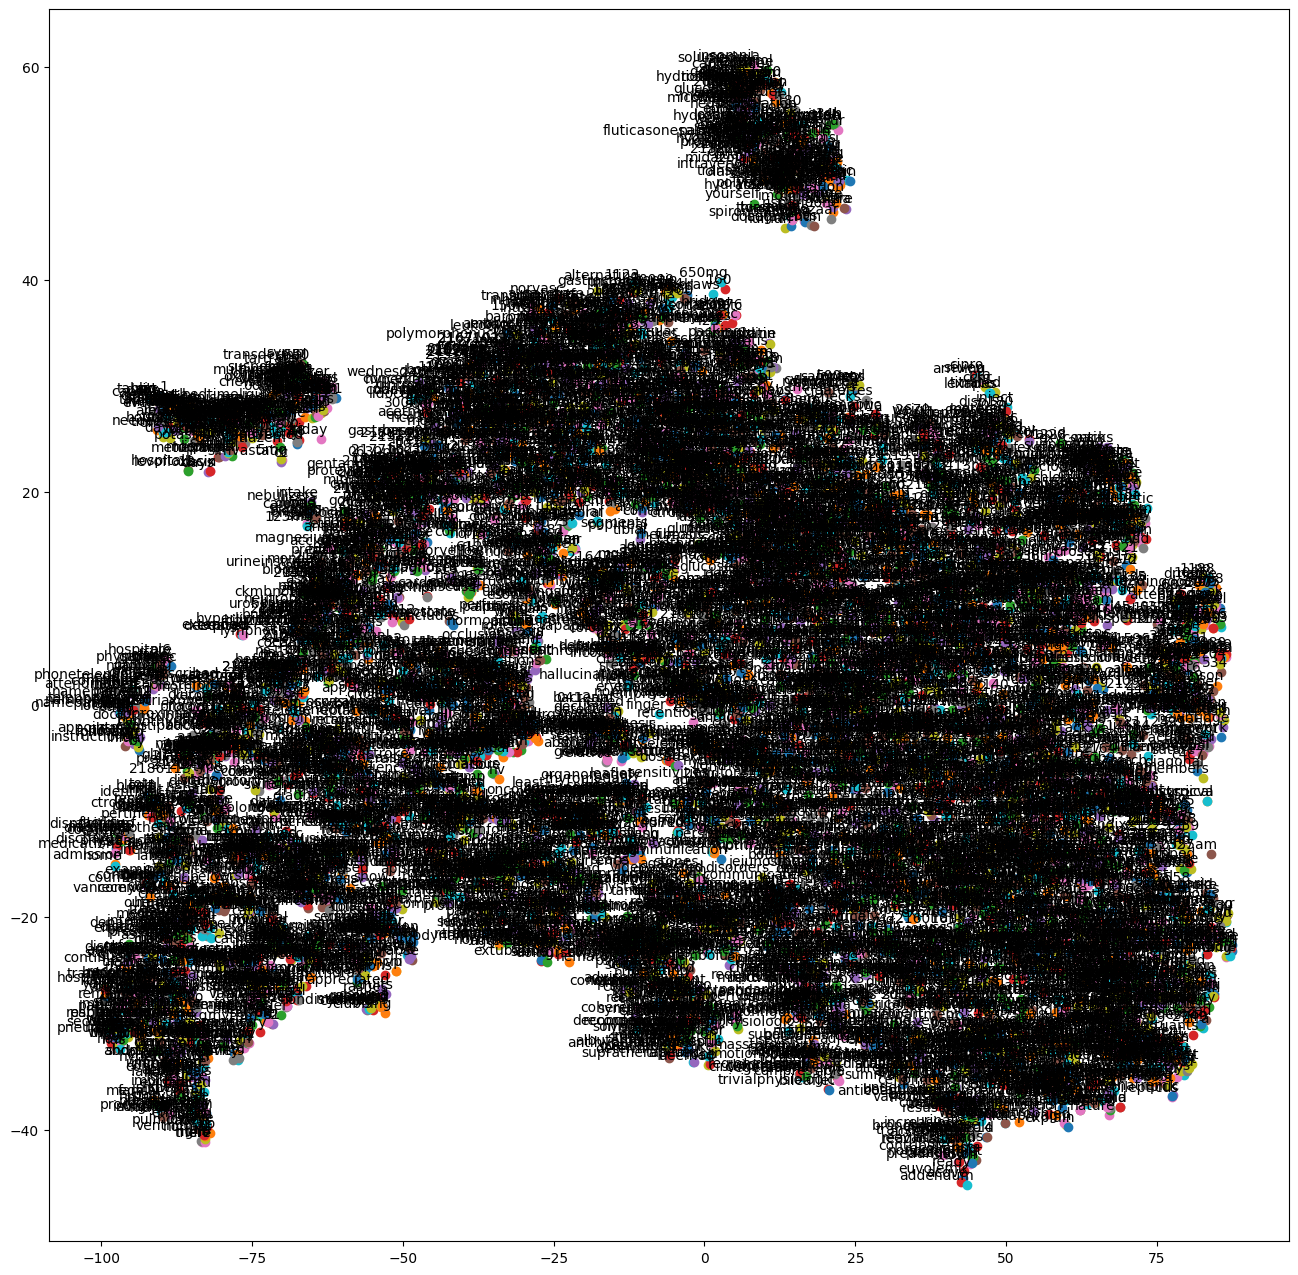

In [28]:
vocabs = model_newly_trained.wv.key_to_index.keys()
new_v = np.array(list(vocabs))
tsne_plot(model_newly_trained, new_v)

c:\Users\william\dev\ut-austin\ai-in-healthcare\.health-310\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


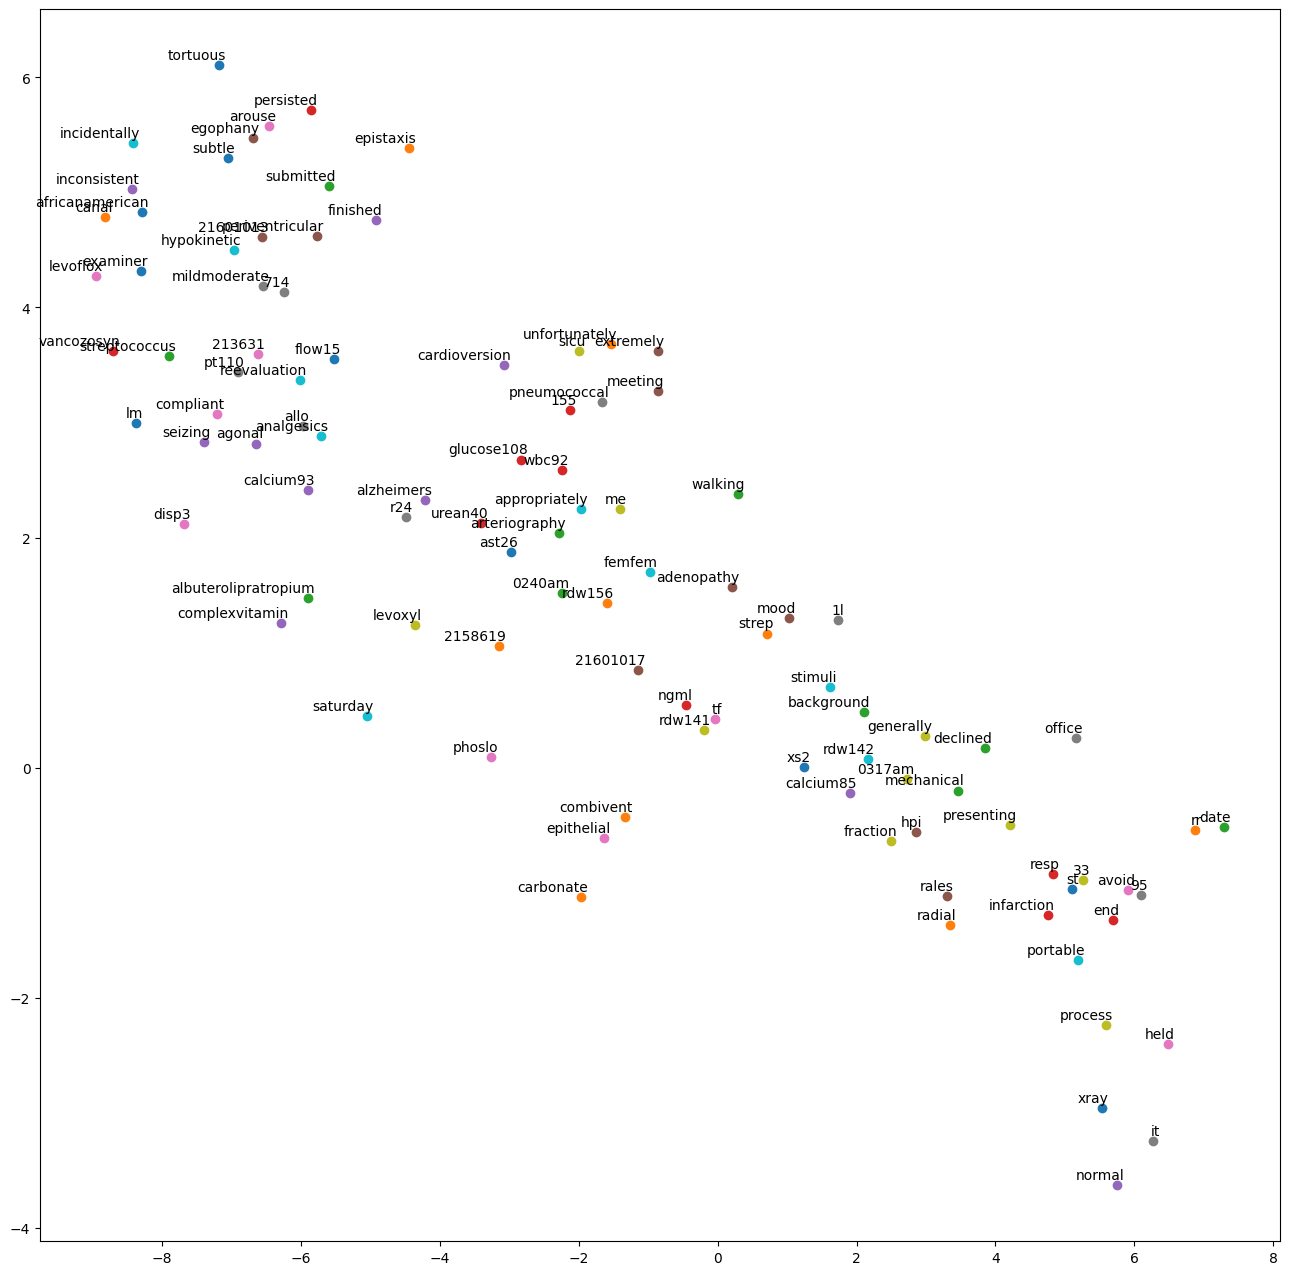

In [32]:
vocabs = model_newly_trained.wv.key_to_index.keys()
sample_size = 100
new_v = np.array(list(vocabs))
tsne_plot(model_newly_trained, new_v, sample_size=sample_size)

Let's try this with a pretrained model from GLOVE.

In [33]:
info = api.info()  # show info about available models/datasets
pretrained_model= api.load("glove-wiki-gigaword-50")  # download the model and return as object ready for use

[==================================================] 100.0% 66.0/66.0MB downloaded


c:\Users\william\dev\ut-austin\ai-in-healthcare\.health-310\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


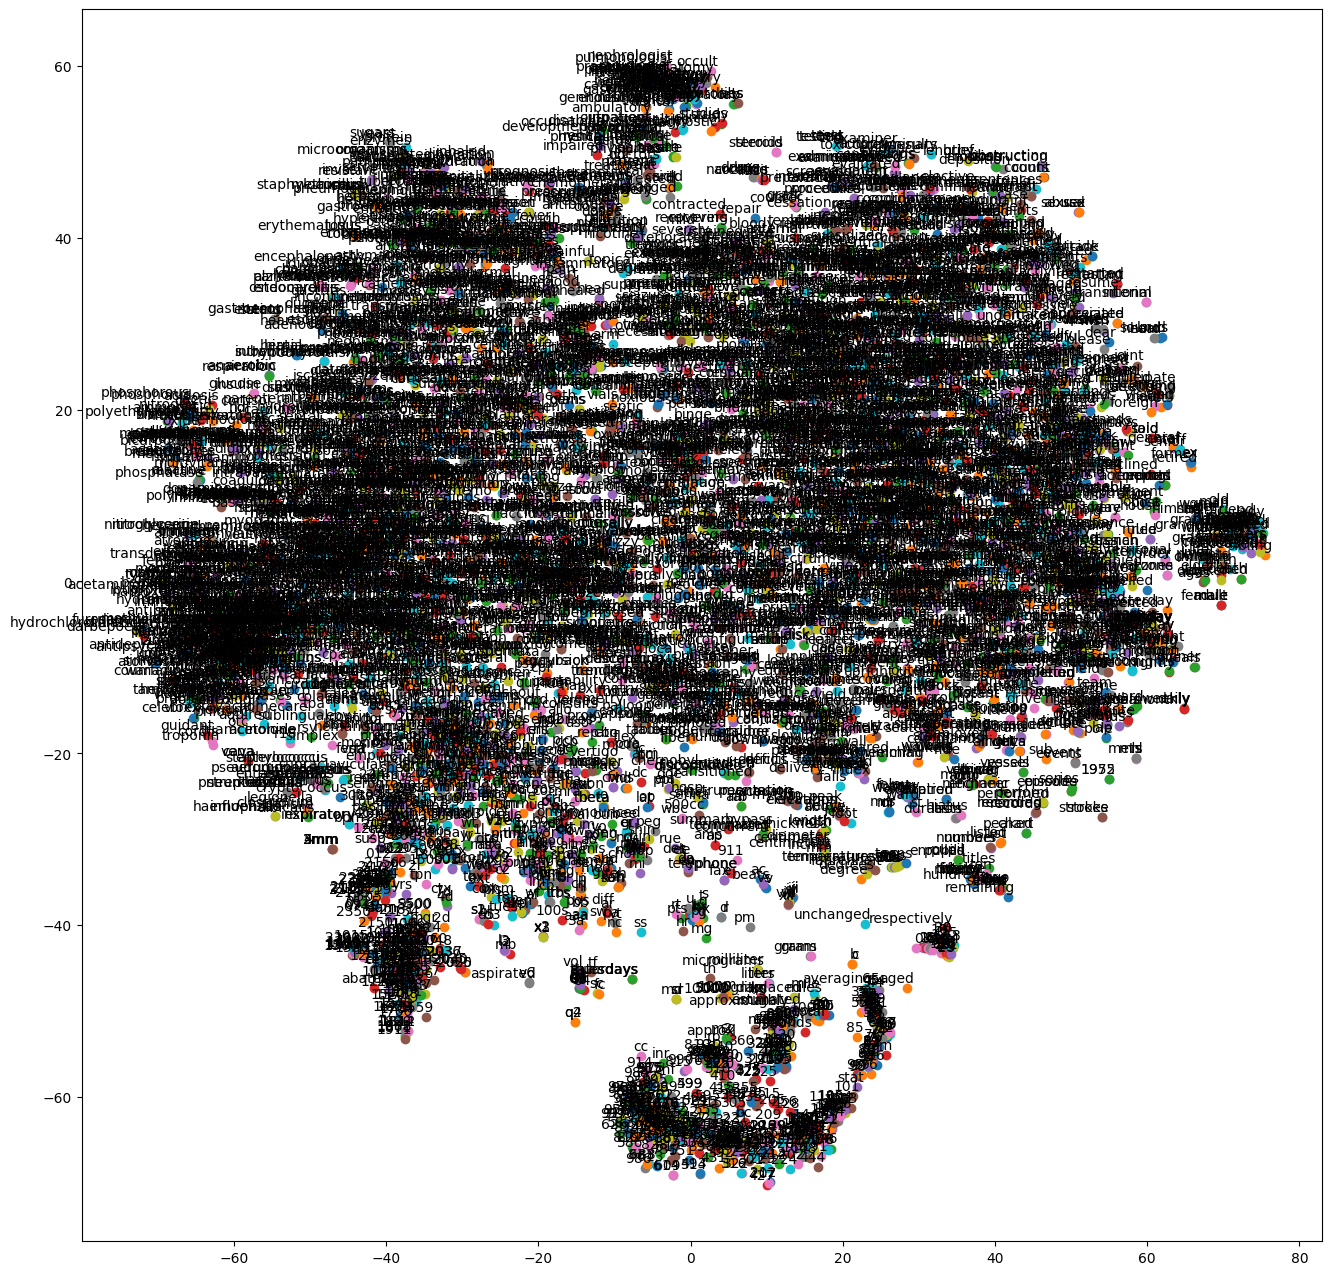

In [36]:
new_corpus_in_pretrained_model = []
for word in new_v:
    if word in pretrained_model.key_to_index:
        new_corpus_in_pretrained_model.append(word)

tsne_plot(pretrained_model, new_corpus_in_pretrained_model, preTrained=True)

c:\Users\william\dev\ut-austin\ai-in-healthcare\.health-310\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


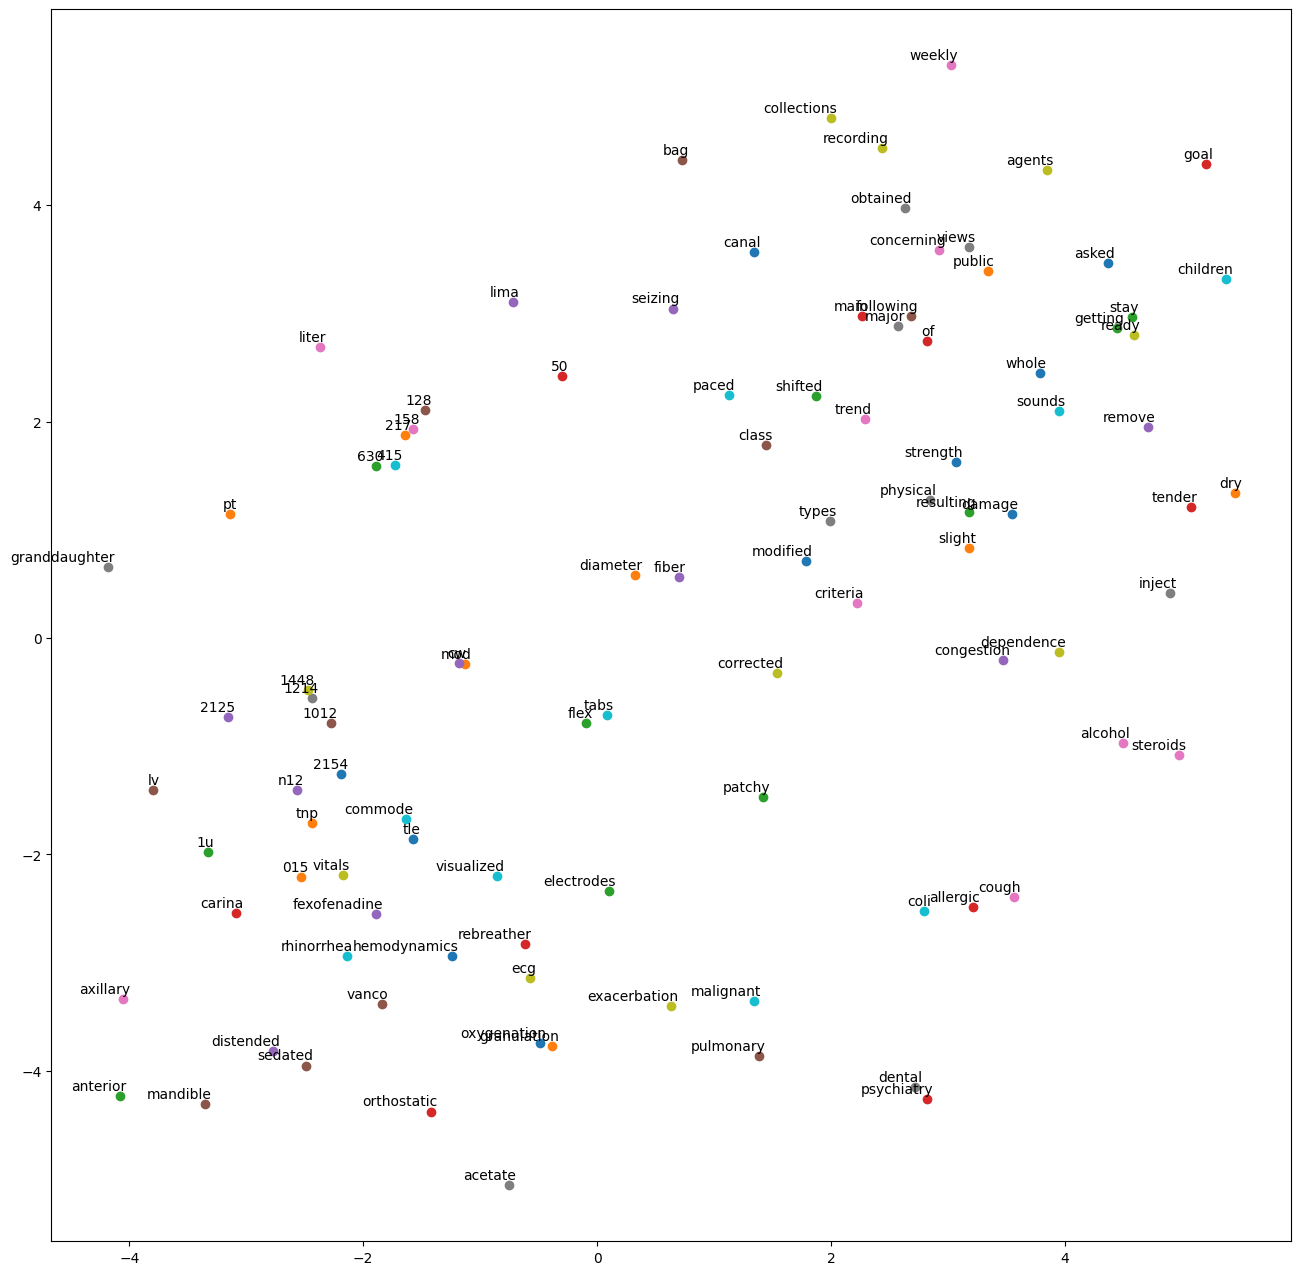

In [37]:
tsne_plot(pretrained_model, new_corpus_in_pretrained_model, sample_size=sample_size, preTrained=True)